## Ideas for expansion
Model the effects of "option 1" in the conference draft on all house districts.

### Data
- House districts
- SLUDs
- SMA
- Honolulu zoning
- Hazards?

### Outputs
- % of house district in each SLUD
- % of house district in SMA
- % of house district zoned residential (- country)

### Process
- Import all data and project to albers hi
#### SLUD
- house overlay SLUD intersection
- calculate areas
- calculate % and save to table
- generate map
- save map as image
- filter to urban only
#### SMA
- house overlay SMA union
- calculate areas
- calculate % and save to table
- generate map
- save map as image
- clip house to no SMA
#### Residential
- use existing zoning files
- filter to residential only
#### Combined result
- Intersect urban SLUD, not in SMA, residential only
- calculate areas
- calculate % and save to table
- generate map
- save map as image

### Bill provisions
#### Option 1:
 (1)  Districts that authorize at least two accessory dwelling units, or the reasonable equivalent, for residential use per each permitted existing single-family dwelling on a residentially zoned lot; provided that these districts shall be:

          (A)  Consistent with the county's comprehensive general plan;

          (B)  Reasonably distributed throughout the county's various regional planning areas; and

          (C)  Estimated to add development potential equivalent to half of the county's projected five-year demand of needed housing units for ownership or rental as stated in the 2019 Hawaii housing planning study; and
#### Exceptions:
     (i)  This section shall not apply to:

     (1)  Any area outside of the urban district established by chapter 205;

     (2)  County powers within special management areas delineated pursuant to chapter 205A; and

     (3)  Any area within an urban district that a county deems to be at high risk of a natural hazard such as flooding, lava, or fire, as determined by the most current data and maps issued by a federal or state department or agency.

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os

In [3]:
house = gpd.read_file('./data/lege/Hawaii_State_House_Districts_2022.geojson')

# keep county, state_house, house_name, geometry
drop_cols = ['objectid', 'house_id',
       'house_abbr', 'st_areashape', 'st_perimetershape']
house = house.drop(drop_cols, axis=1)

# Project to NAD 1983 Albers Hawaii for area calculations https://epsg.io/102007 -- 41s
original_crs = house['geometry'].crs

albers_hi = '+proj=aea +lat_0=13 +lon_0=-157 +lat_1=8 +lat_2=18 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs'
house['geometry'] = house['geometry'].to_crs(albers_hi)

# calculate house area
house['house_area'] = house.area

# project back to other crs
house['geometry'] = house['geometry'].to_crs(original_crs)

## SLUD
- house overlay SLUD intersection
- calculate areas
- calculate % and save to table
- generate map
- save map as image
- filter to urban only

In [5]:
# import data
# FIXME this SLUD file only has Oahu
slud = gpd.read_file('./data/State_Land_Use_Districts.geojson')


c:\Users\curly\miniconda3\envs\geoanalysis\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
c:\Users\curly\miniconda3\envs\geoanalysis\Lib\site-packages\geopandas\io\file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


In [11]:
house_by_slud = house.overlay(slud, how = 'intersection')

In [12]:
# project result to albers
house_by_slud['geometry'] = house_by_slud['geometry'].to_crs(albers_hi)

# calculate slud areas in house districts
house_by_slud['slud_in_house_area'] = house_by_slud.geometry.area

# Aggregate to see slud % by 
house_slud_pct = house_by_slud.groupby(['state_house', 'lud_code']).agg({
    'house_name': 'first',
    'county': 'first',
    'slud_in_house_area': 'sum',
    'house_area': 'first'
})

# calculate % area for each slud
house_slud_pct['slud_pct'] = house_slud_pct['slud_in_house_area'] / house_slud_pct['house_area']

# round for clean analysis
house_slud_pct['slud_pct'] = round(house_slud_pct['slud_pct'], 3) * 100

# export to file
house_slud_pct.to_csv('./output/house_slud_pct.csv')

In [15]:
# filter to urban district and reproject to prep intersection
slud = slud[slud['lud_code'] == 1]
slud['geometry'] = slud['geometry'].to_crs(original_crs)

<Axes: >

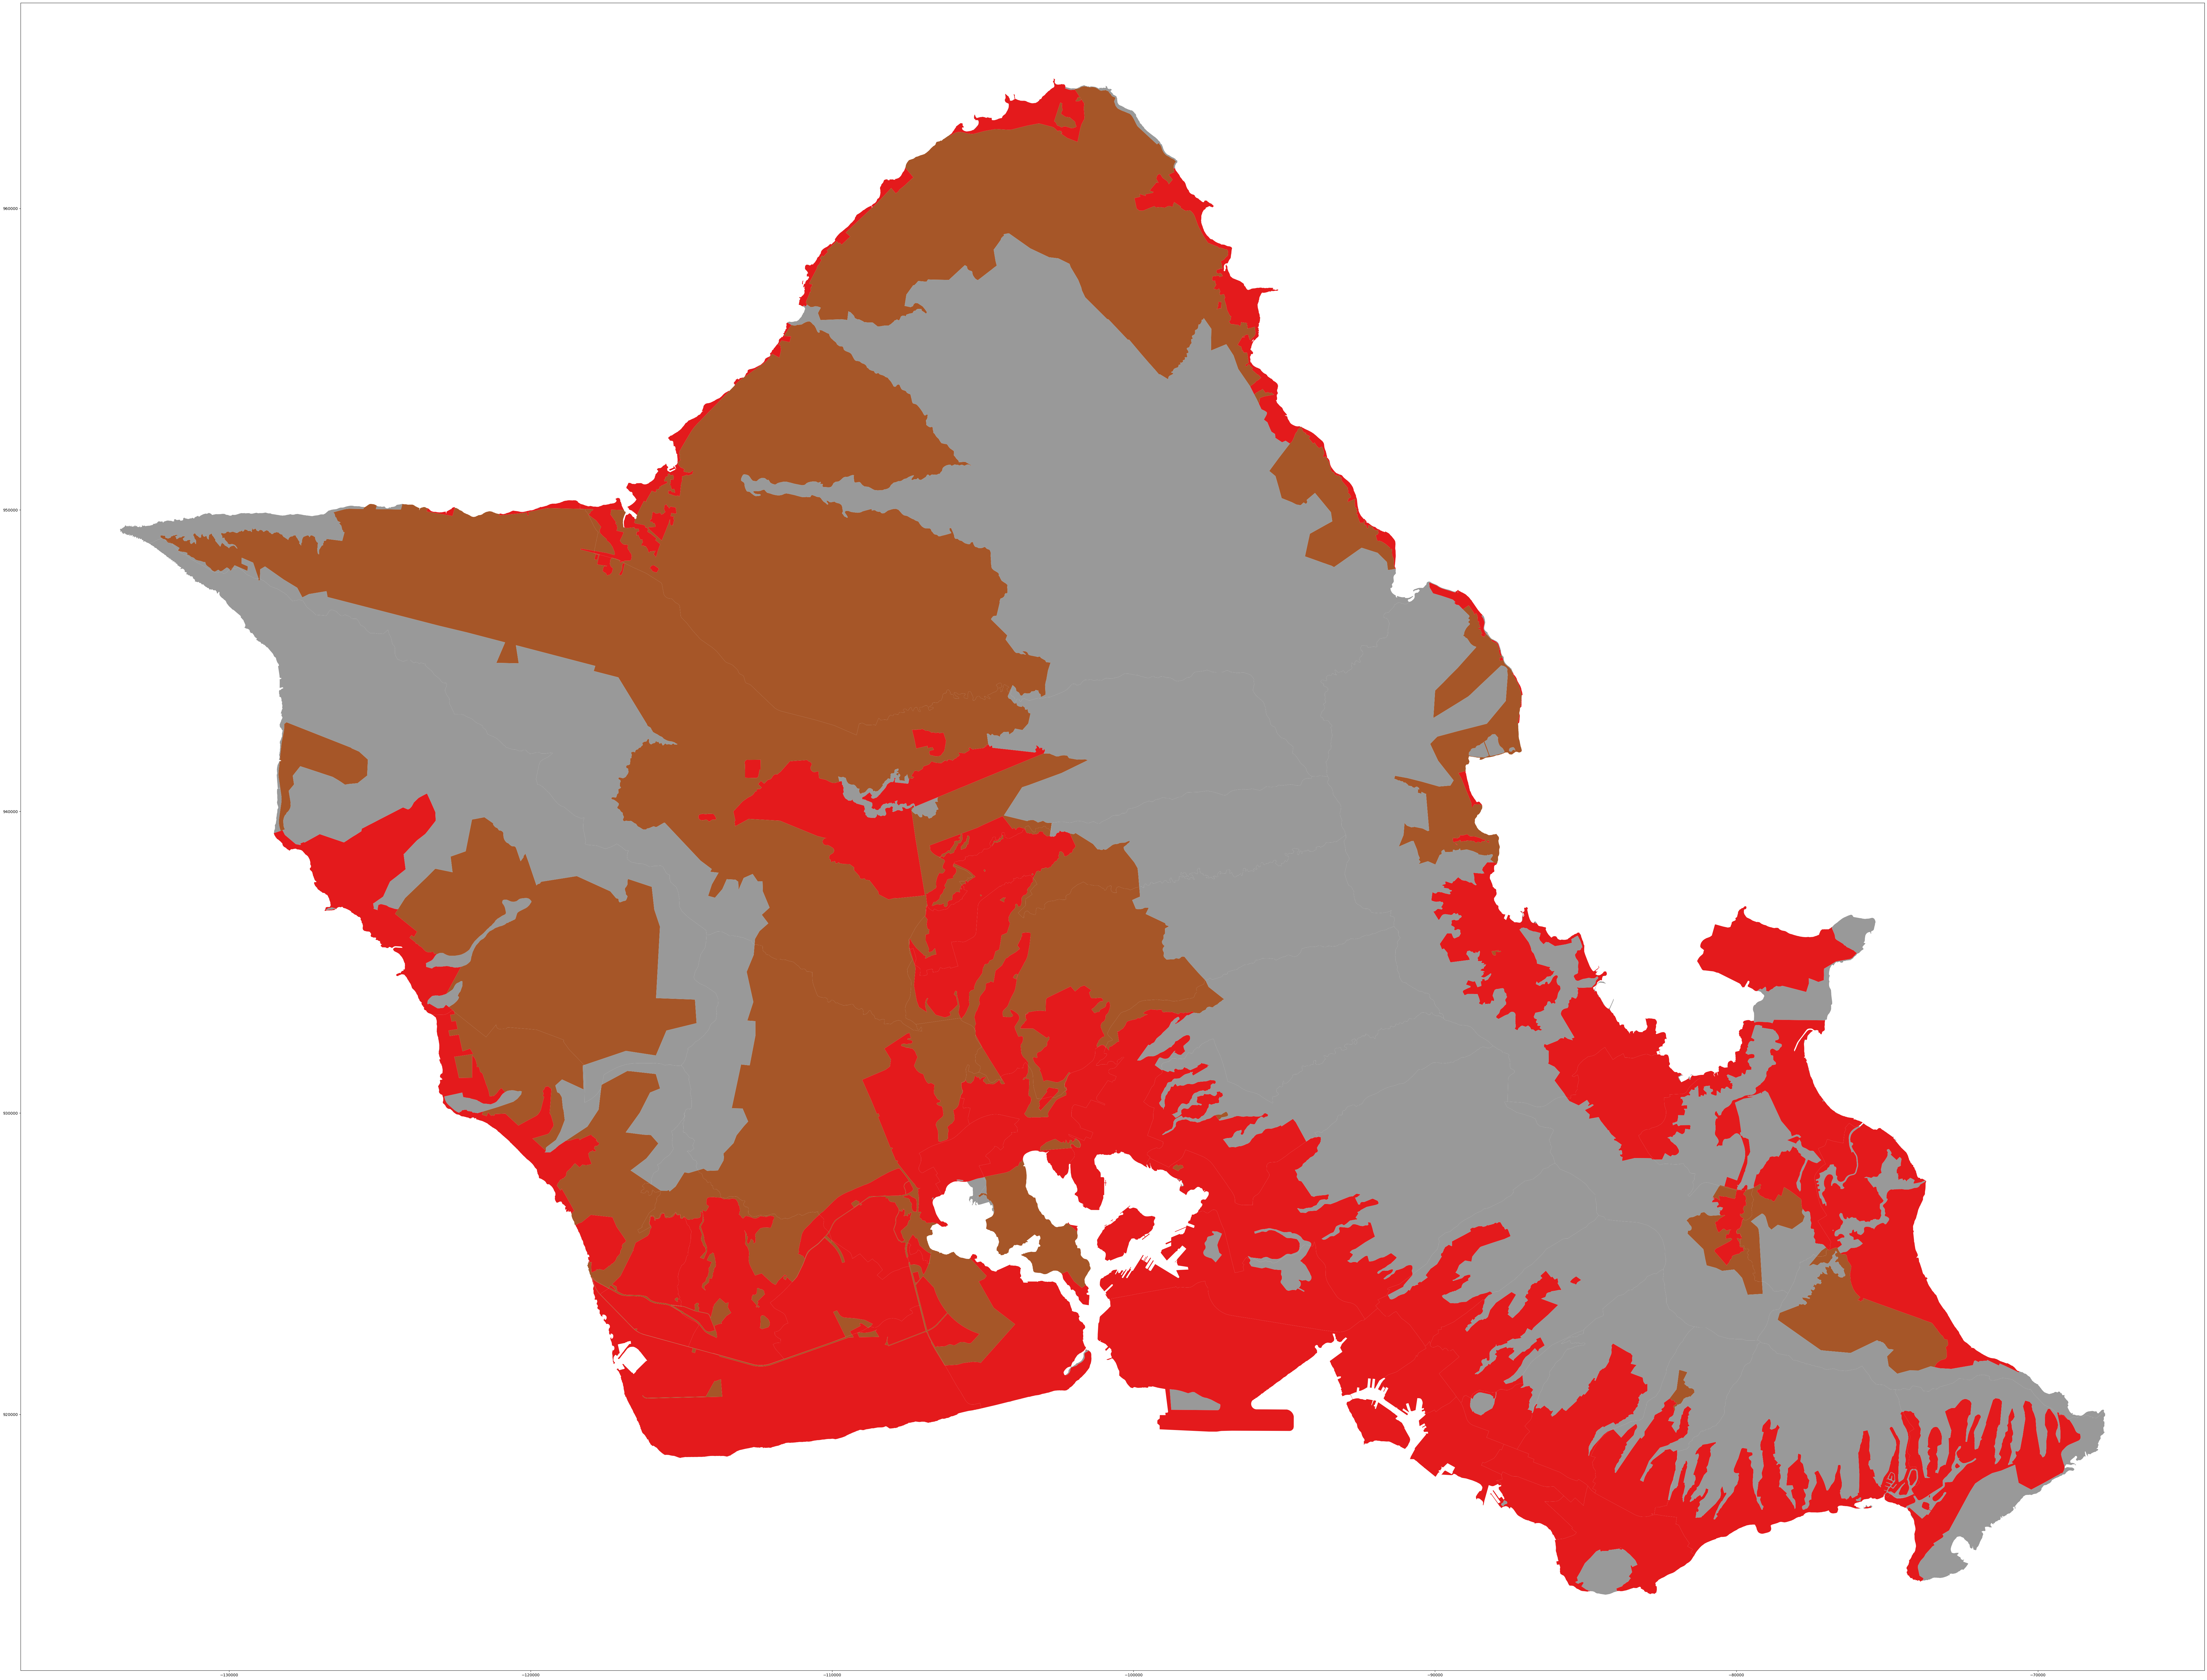

In [14]:
house_by_slud.plot(column='lud_code', 
           cmap='Set1',
           figsize=(100, 100))

# SMA
- house overlay SMA union
- calculate areas
- calculate % and save to table
- generate map
- save map as image
- clip house to no SMA

In [14]:
sma = gpd.read_file('./data/Special_Management_Areas_(SMA).geojson')
len(sma)

45

In [1]:
# dissolve SMA to single shape for union
sma = sma.dissolve(by='smarea')

NameError: name 'sma' is not defined

In [9]:
house_by_sma = house.overlay(sma, how = 'union')

KeyboardInterrupt: 

In [18]:
house_by_sma.head()

county state_house              house_name    house_area  objectid  smarea  \
0  HAWAII         H01  State House District 1  2.024909e+09      11.0     1.0   
1  HAWAII         H02  State House District 2  5.677006e+07      11.0     1.0   
2  HAWAII         H03  State House District 3  2.370837e+08      11.0     1.0   
3  HAWAII         H04  State House District 4  7.324968e+08      11.0     1.0   
4  HAWAII         H05  State House District 5  4.696085e+09      11.0     1.0   

         acres  st_areashape  st_perimetershape  \
0  97581.01365  3.948964e+08       1.187721e+06   
1  97581.01365  3.948964e+08       1.187721e+06   
2  97581.01365  3.948964e+08       1.187721e+06   
3  97581.01365  3.948964e+08       1.187721e+06   
4  97581.01365  3.948964e+08       1.187721e+06   

                                            geometry  
0  MULTIPOLYGON (((-155.66601 20.09965, -155.6657...  
1  POLYGON ((-155.08710 19.72788, -155.08707 19.7...  
2  MULTIPOLYGON (((-155.06698 19.74378, -155.0668...  
3  MULTIPOLYGON (((-154.94210 19.60027, -154.9420...  
4  MULTIPOLYGON (((-155.61253 18.97072, -155.6125...

In [ ]:
house_by_sma['sm_area'].value_counts()

# SF Residential

In [41]:
honolulu = gpd.read_file('./data/zoning_maps/HonoluluCountyHonoluluCountyHI-ZoningDistricts.geojson')
honolulu = honolulu[['Jurisdiction','Abbreviated District Name', '1-Family Treatment', 'geometry']]


In [42]:
# Actual affected area, all "residentially zoned lots"
# honolulu = honolulu[honolulu['1-Family Treatment'] == "Allowed/Conditional"]

# one-hot flag for single-family, works for Honolulu only (see HDA for all county implmentation)
honolulu['single_family'] = honolulu['Abbreviated District Name'].str.startswith("R-")

honolulu = honolulu[honolulu['single_family'] == True]

# Combined Analysis

<Axes: >

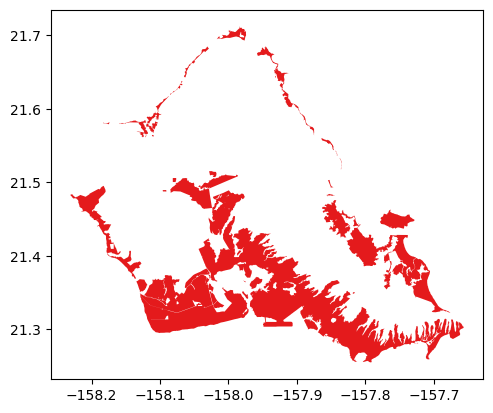

In [43]:
slud = slud[slud['lud_code'] == 1]
slud.plot(column='lud_code',cmap='Set1')

<Axes: >

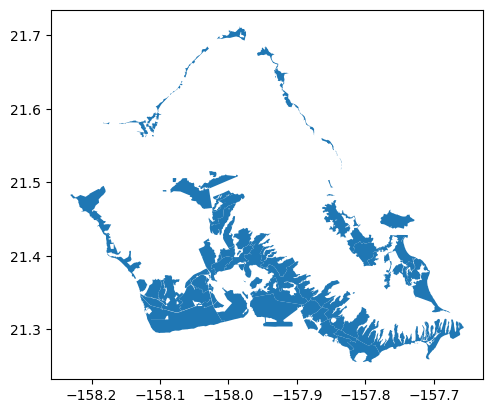

In [44]:
gdf = house.overlay(slud, how = 'intersection')
gdf.plot()

<Axes: >

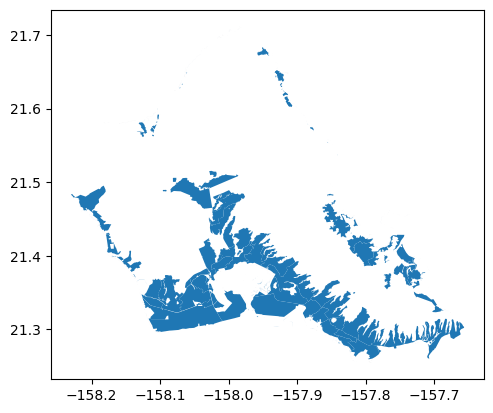

In [45]:
gdf = gdf.overlay(sma, how = 'difference')
gdf.plot()

<Axes: >

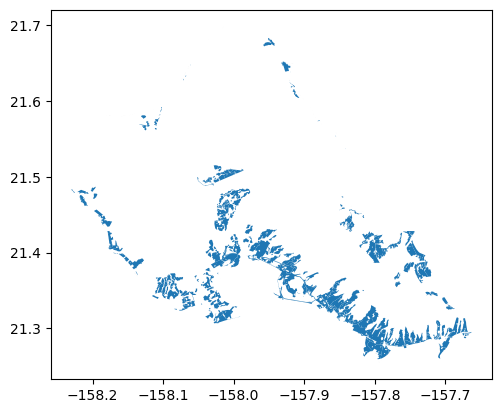

In [46]:
gdf = gdf.overlay(honolulu, how = 'intersection')
gdf.plot()

In [47]:
gdf = gdf.dissolve(by='house_name')
len(gdf)

31

In [48]:
gdf['geometry'] = gdf['geometry'].to_crs(albers_hi)

gdf['affected_area'] = gdf.geometry.area

In [49]:
gdf['affected_area'].sum() / gdf['house_area'].sum()

0.09541432836585513

In [54]:
effective_area = gdf.groupby('house_name').agg({
    'house_area' : 'first',
    'affected_area' : 'sum'
})

effective_area['affected_pct'] = effective_area['affected_area'] / effective_area['house_area']
effective_area

house_area  affected_area  affected_pct
house_name                                                        
State House District 18  2.658328e+07   6.589387e+06      0.247877
State House District 19  3.533054e+07   8.688062e+06      0.245908
State House District 20  1.093927e+07   5.146816e+06      0.470490
State House District 21  1.521173e+07   5.890808e+06      0.387254
State House District 22  1.913111e+07   7.100267e+06      0.371137
State House District 26  4.799805e+06   1.200674e+06      0.250151
State House District 27  2.098153e+07   6.275466e+06      0.299095
State House District 28  5.667134e+06   8.414009e+05      0.148470
State House District 29  1.713994e+07   4.628680e+06      0.270052
State House District 30  2.928437e+07   1.979851e+06      0.067608
State House District 31  1.623930e+07   3.022897e+06      0.186147
State House District 32  5.217691e+07   5.887202e+06      0.112832
State House District 33  2.718375e+07   6.271311e+06      0.230701
State House District 34  3.882011e+07   6.127703e+06      0.157849
State House District 35  1.736304e+07   4.006632e+06      0.230756
State House District 36  4.744249e+06   2.615183e+06      0.551232
State House District 37  6.091597e+07   5.832156e+06      0.095741
State House District 38  3.283374e+07   4.557273e+06      0.138798
State House District 39  6.920977e+07   5.300538e+06      0.076587
State House District 40  2.116172e+07   2.784400e+06      0.131577
State House District 41  3.591949e+07   3.102385e+06      0.086371
State House District 42  1.117761e+07   3.117222e+06      0.278881
State House District 43  2.199583e+07   5.828513e+06      0.264983
State House District 44  4.494303e+07   5.960010e+06      0.132613
State House District 45  1.273360e+08   3.450472e+06      0.027097
State House District 46  2.257898e+08   5.637315e+06      0.024967
State House District 47  3.528932e+08   3.143189e+06      0.008907
State House District 48  8.289506e+07   3.958715e+06      0.047756
State House District 49  3.323707e+07   5.867546e+06      0.176536
State House District 50  4.376617e+07   7.286837e+06      0.166495
State House District 51  3.697374e+07   5.091455e+06      0.137705

In [60]:
effective_area.nlargest(5, 'affected_pct')

house_area  affected_area  affected_pct
house_name                                                        
State House District 36  4.744249e+06   2.615183e+06          55.1
State House District 20  1.093927e+07   5.146816e+06          47.0
State House District 21  1.521173e+07   5.890808e+06          38.7
State House District 22  1.913111e+07   7.100267e+06          37.1
State House District 27  2.098153e+07   6.275466e+06          29.9

In [55]:
# round for clean analysis
effective_area['affected_pct'] = round(effective_area['affected_pct'], 3) * 100

# export to file
effective_area.to_csv('./output/conference_effective_area.csv')

# Final plot

In [56]:
gdf['geometry'] = gdf['geometry'].to_crs(original_crs)

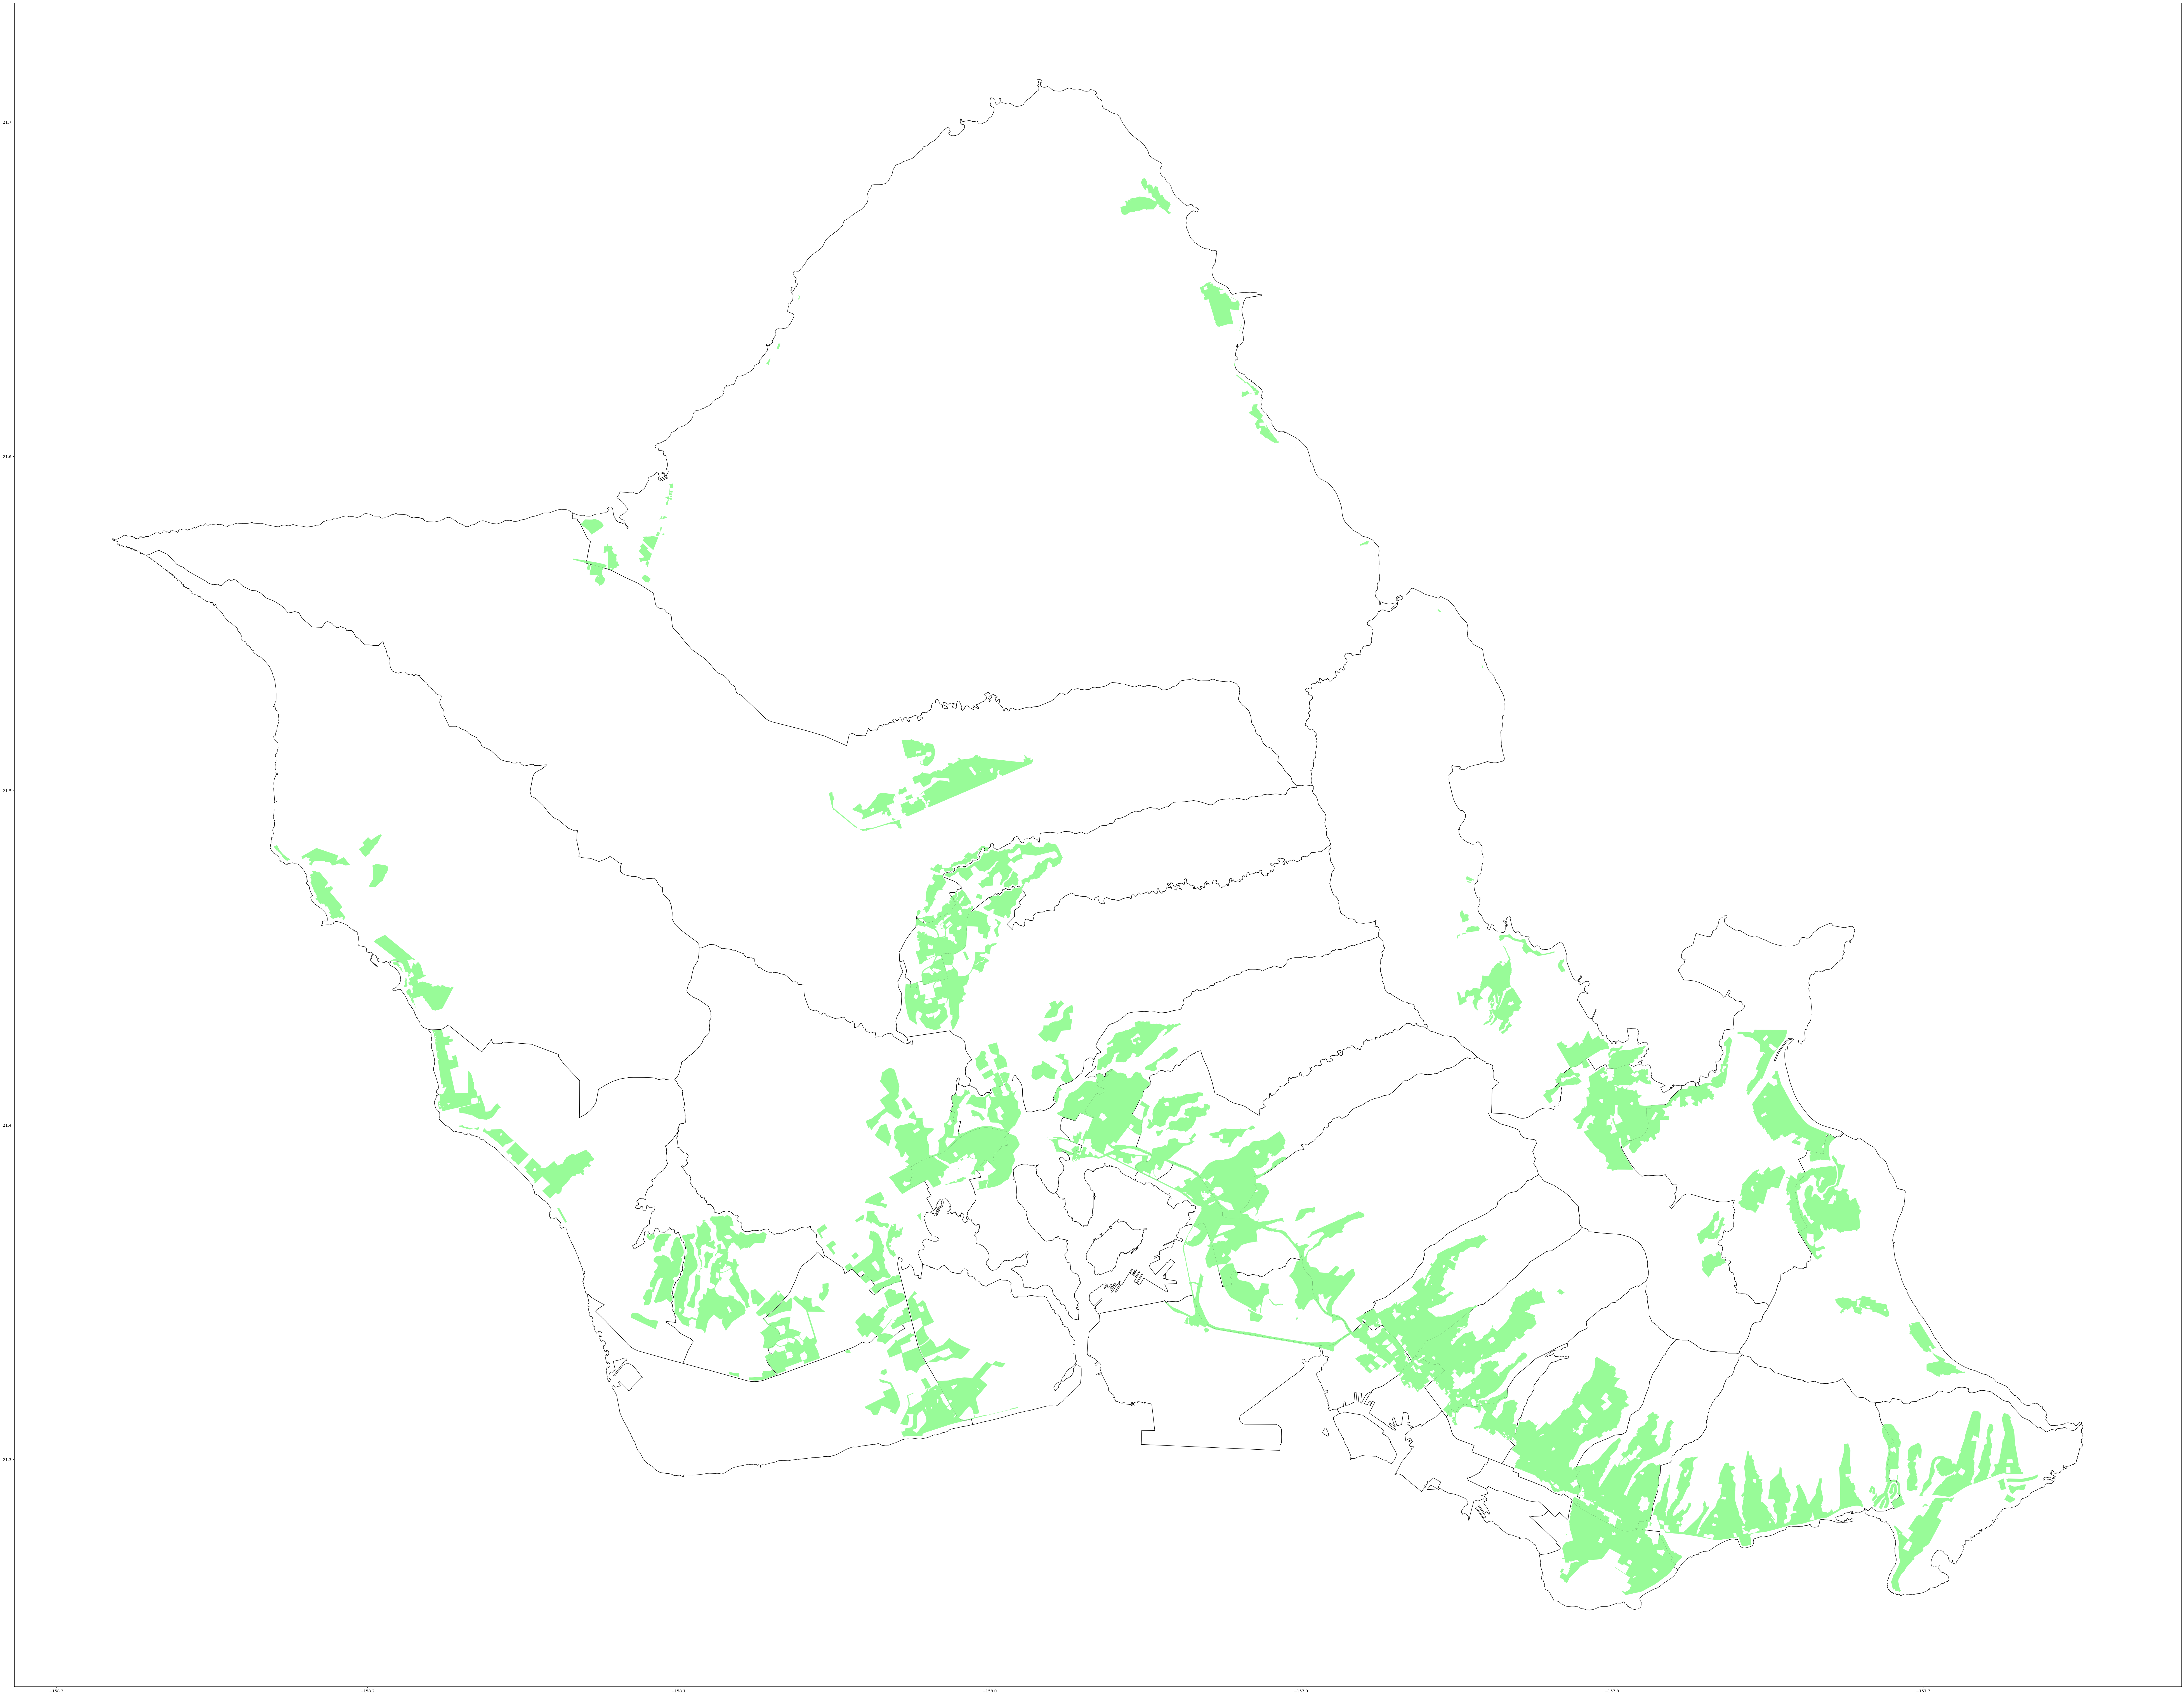

In [58]:
base = house[house['county'] == 'OAHU'].plot(color='white', edgecolor='black', figsize=(100,100))
final_plot = gdf.plot(ax=base, color="palegreen")
final_plot.figure.savefig('./output/oahu_affected_area_by_house.png')

In [ ]:
finalplot